Simulations for understanding the contribution of distance dependence curves to reproducibility decrease upon noise injection
==

In [139]:
import numpy as np
import os
import sys
import gzip
import subprocess as subp
import re
import copy
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import matplotlib
import matplotlib.patches as patches
import math
from scipy.stats.mstats import mquantiles
from random import randint
from sklearn.metrics.cluster import adjusted_rand_score
from scipy import stats
from matplotlib import cm
import pandas as pd
import math
import scipy
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist 
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix
from scipy.ndimage import rotate
sys.path.append('/srv/gsfs0/projects/snyder/oursu/software/git/public_genomedisco/genomedisco/genomedisco')
import processing
import pybedtools
import data_operations
from pylab import rcParams
import random

%matplotlib inline

In [140]:
#===== CODE from Gurkan =========

#CM is the contact matrix to be subsampled, subsampleN is the number 
#of interactions to choose
def SubSampleMatrix(CM, subSampleN = 1000000 ):

	if subSampleN == 0 :
		return(CM)

	index1 = []
	index2 = []
	subCM = np.zeros((len(CM),len(CM)))

	#fill two lists with interactions from the matrix
	# i.e. if Mij == 20, we enter 20 'i's into index1 
	# 20 'j's into index2
	for i in range(len(CM)):
		for k in range(i,len(CM)):
			count = int(CM[i,k])
			v1=np.empty(count); v1.fill(i)				
			v2=np.empty(count); v2.fill(k)				
			index1.extend(v1); index2.extend(v2)
	
	#convert lists to numpy arrays 
	index1 = np.array(index1)
	index2 = np.array(index2)
	#make a shuffled index for the lists
	shufIndex = range(0,len(index1));	random.shuffle(shufIndex);
	#sample 'subsampleN' interactions from the lists
	subSampleIndex = np.random.choice(shufIndex,size=subSampleN,replace=False)
	index1 = index1[subSampleIndex]
	index2 = index2[subSampleIndex]

	#Create the subsampled matrix from two lists
	for i in range(len(index1)):
		a = int(index1[i]); b = int(index2[i])
		subCM[a,b] = subCM[a,b] + 1

	#fill the lower triangle of matrix
	subCM = subCM + np.triu(subCM,1).T		
	return(subCM)


# sample from vector V, stratified by entries in F
# vector V contains entries of matrix Mij
# vector F contains multiples of marginals mi * mj
# strataSize determines the number of entries in each stratum
def stratifiedSample ( V, F, strataSize = 100 ):
	#convert to numpy arrays
	N = len(V)
	V = np.array(V)
	F = np.array(F)

	#sort vector F and crerate lists for strata
	strataCount = int(np.ceil(float(N) / strataSize))
	sortInd = np.argsort(F)
	strata = []
	strataMax = []
	
	# fill each strata with 'strataSize' members
	# record the maximum F value of each stratum
        for i in range(strataCount) :
                stratum = V [ sortInd[ (strataSize*(i) ) : (strataSize*(i+1)) ] ]
                stratumF = F [ sortInd[ (strataSize*(i) ) : (strataSize*(i+1)) ] ]
                strata.append( stratum )
                strataMax.append(max(stratumF))


	#Make a sample vector
	sample = []
	for i in range(len(V) ):
		# find which stratum Fi belongs to
		for k in range(strataCount) :
			if ( F[i] <= strataMax[k] ):
				#stratumInd = k
				break
		#sample from the stratum we picked
		sample.append ( np.random.choice(strata[k],size=1)[0] )

	return ( sample )

#Make a uniform matrix where every entry is equally likely
# instead of specifying number of rows and columns, we pass a
# matrix. subsampleCount determines how many interactions to fill the matrix
def uniformMatrix ( CM, subSampleCount = 1000000, bias = True ):
        (R,C) = np.shape(CM)
        marginal = np.reshape( np.sum(CM,0), np.shape(CM)[0] )
        uniSampleCM = np.matrix( np.zeros((R,C)) )
        #triuSum = sum(np.arange(R)+1)

        indexMap = []
        indexProb = []
        for i in range(R) :
                for k in range(i,R) :
                        if marginal[i] != 0 and marginal[k] != 0 :
                                indexMap.append([i,k])
                                if bias :
                                        indexProb.append(marginal[i] * marginal[k])

        if bias :
                totalProb = float(sum(indexProb))
                indexProb = [ iP / totalProb for iP in indexProb ]
                triuSample = np.random.choice(len(indexMap),subSampleCount,p=indexProb)
        else :
                triuSample = np.random.choice(len(indexMap),subSampleCount)

        for s in triuSample :
                (i,k) = indexMap[s]
                uniSampleCM[i,k] += 1
        uniSampleCM += np.transpose(np.triu(uniSampleCM,1))

        return (uniSampleCM)


def shuffleMatrix ( CM ):
	#Convert to integer
	CM = CM.astype(int)
	#Get marginals and number of rows
	contactSum = sum(CM)
	N = len(CM)

	# For matrix entry Mik, store Marginal i * Marginal k in CountByDist
	# and the Mik itself in matrixByDist, these lists are indexed by distance 

	countByDist = []
	matrixByDist = []
	for i in range(0,N):
		for k in range(i,N):
			dist = k-i
			if ( len(countByDist)-1 < dist ):
				countByDist.append( [ float(contactSum[i]) * contactSum[k] ] )
				matrixByDist.append( [ int( CM[i,k] ) ] )
			else:
				countByDist[dist].append( float(contactSum[i]) * contactSum[k] )
				matrixByDist[dist].append( int( CM[i,k] ) )

	#Create an empty matrix	
	noiseMatrix = np.zeros((N,N))

	#For each dist (diagonal), do a stratified sampling and fill that diagonal
	for i in range(len(matrixByDist)):
		thisSample = stratifiedSample(matrixByDist[i],countByDist[i],50)
		for k in range(len(thisSample)):				
			noiseMatrix[k,k+i] = thisSample[k]

	#Fill the lower triangle of matrix		
	noiseMatrix = noiseMatrix + np.triu(noiseMatrix,1).T		

	return ( noiseMatrix )

#and my code

def get_distance_dep(m):
    assert m.shape[0]==m.shape[1]
    dcounts={}
    pcounts={}
    #get all distances we'll want to take into account
    total_reads=0.0
    for di in range(m.shape[0]):
        dcounts[di]=0
        pcounts[di]=0
    for i in range(m.shape[0]):
        for j in range(i,m.shape[0]):
            di=abs(i-j)
            dcounts[di]+=m[i,j]
            total_reads+=m[i,j]
    for di in range(m.shape[0]):
        pcounts[di]=1.0*dcounts[di]/((m.shape[0]-di)*total_reads)
    return pcounts


**1. Random ligation noise flattens the distance dependence** 

Plot how the distance curve changes as a function of random noise addition. Do this for samples from Rao (independent of ENCODE).
Focus exclusively on the random ligation noise, which I believe to be responsible for the behavior of GenomeDISCO studied here (perUniform=1).

In [82]:
celltypes=['GM12878_combined']

perUniform=1.0
noises=[0.01,0.25,0.5,0.75]
resolution=50000
nodefile='/ifs/scratch/oursu/data/chr21_datasets/nodes.50000.chr21.gz'
#nodefile='/ifs/scratch/oursu/3d/paper/2017-06-08/LA/reproducibility/res40000/data/nodes/nodes.chr21.gz'
nodes,nodes_idx=processing.read_nodes_from_bed(nodefile)

noise={}
for celltype in celltypes:
    print celltype
    noise[celltype]={}
    #mname='/ifs/scratch/oursu/3d/paper/2017-06-08/LA/reproducibility/res40000/data/edges/'+celltype+'/'+celltype+'.chr21.gz'
    mname='/ifs/scratch/oursu/data/chr21_datasets/'+celltype+'.chr21.RAWobserved.gz'
    rawCM = processing.construct_csr_matrix_from_data_and_nodes(mname,nodes,True).toarray()# read in my matrix
    rawCM=rawCM+rawCM.T
    
    for perNoise in noises:
        
        #total number of interactions
        Coverage = int( np.sum(rawCM) / 2 + np.sum(np.diagonal(rawCM)) / 2 )

        print 'Generating shuffle noise'
        shuffleCM = shuffleMatrix(rawCM)

        # We generate a uniform sample that incorporates bin(row) specifc biases
        # bias=False will ignore those biases
        print 'Generating uniform noise'
        uniformCM = uniformMatrix(rawCM,np.sum(rawCM),bias=True)

        print 'Done generating noise'

        #Mix matrices
        sRawCM = SubSampleMatrix(rawCM, subSampleN = int(Coverage * ( 1 - float(perNoise) ) ) )
        sShuffleCM = SubSampleMatrix(shuffleCM, subSampleN = int(Coverage * float(perNoise) * float(1-perUniform) ) )
        sUniformCM = SubSampleMatrix(uniformCM, subSampleN = int(Coverage * float(perNoise) * float(perUniform) ) )
        noisedCM = sRawCM + sShuffleCM + sUniformCM
        noise[celltype][perNoise]=copy.deepcopy(noisedCM)
    

GenomeDISCO | Thu Jun 29 22:32:19 2017 | processing: Loading genomic regions from /ifs/scratch/oursu/data/chr21_datasets/nodes.50000.chr21.gz
num nodes
963
GM12878_combined
GenomeDISCO | Thu Jun 29 22:32:19 2017 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/GM12878_combined.chr21.RAWobserved.gz
Generating shuffle noise
Generating uniform noise


/srv/gsfs0/projects/snyder/oursu/software/anaconda2/mypython/lib/python2.7/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise


In [83]:
dd={}
for celltype in celltypes:  
    dd[celltype]={}
    for perNoise in noises:
        dd[celltype][perNoise]=get_distance_dep(noise[celltype][perNoise])

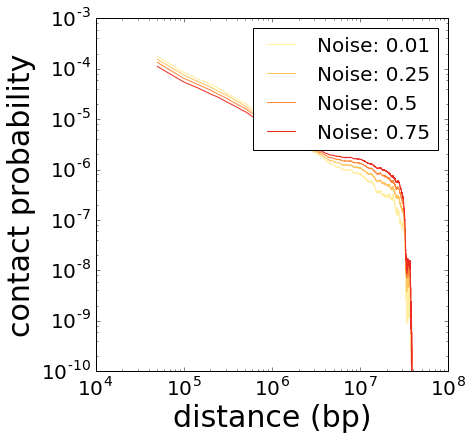

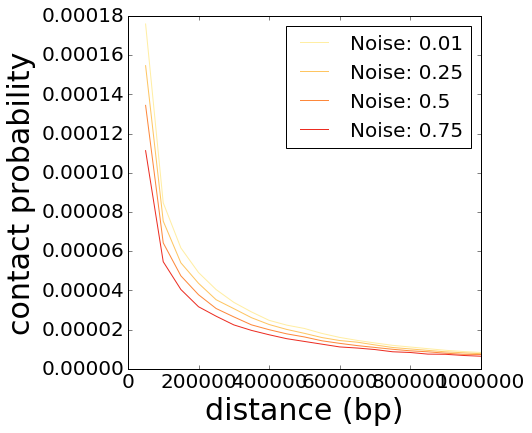

In [86]:
def plot_dds(dd_list,dd_names,out,approximation,dolog):
    assert len(dd_list)==len(dd_names)

    rcParams['figure.figsize'] = 7,7
    rcParams['font.size']= 30
    rcParams['xtick.labelsize'] = 20
    rcParams['ytick.labelsize'] = 20
    fig, plots = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(7, 7)
    #colors=['red','blue','green','pink']
    cmap = plt.cm.YlOrRd
    # extract all colors from the .jet map
    colors = [cmap(30+i*50) for i in range(len(dd_names))]
    for dd_idx in range(len(dd_names)):
        dd_name=dd_names[dd_idx]
        dd=list(dd_list[dd_idx].values())
        x=list(dd_list[dd_idx].keys())
        sorted_x=np.argsort(np.array(x))
        x_plot=[]
        dd_plot=[]
        x_idx=0
        while x_idx<len(x):
            x_plot.append(x[sorted_x[x_idx]]*approximation)
            dd_plot.append(dd[sorted_x[x_idx]])
            x_idx+=1
        '''
        x_plot=x
        dd_plot=dd
        '''
        plots.plot(x_plot[1:],dd_plot[1:],c=colors[dd_idx],label=dd_names[dd_idx]) #c=colors[dd_idx],
    if dolog=='log':
        plots.set_yscale('log',basey=10)
        plots.set_xscale('log',basex=10)
    else:
        plots.set_xlim(0,1000000)
    plots.set_xlabel('distance (bp)')
    plots.set_ylabel('contact probability')
    plots.legend(loc=1,fontsize=20)
    #plots.set_xlim(0,100000)
    #fig.tight_layout()
    adj=0.2
    plt.gcf().subplots_adjust(bottom=adj)
    plt.gcf().subplots_adjust(left=adj)

for celltype in celltypes: 
    plot_dds([dd[celltype][0.01],dd[celltype][0.25],dd[celltype][0.5],dd[celltype][0.75]],
             ['Noise: 0.01','Noise: 0.25','Noise: 0.5','Noise: 0.75'],'out',50000,'log')
    plot_dds([dd[celltype][0.01],dd[celltype][0.25],dd[celltype][0.5],dd[celltype][0.75]],
             ['Noise: 0.01','Noise: 0.25','Noise: 0.5','Noise: 0.75'],'out',50000,'nonlog')

Notice how with increasing random logation noise, the distance dependence curve flattens.

**2. In absence of structural differences, the rate of decrease of the GenomeDISCO score is dictated by the flatness of the distance dependence curve**

Take 1 dataset. Rescale its values to have 2 distance curves, one flatter than the other one. 
This allows us to measure the sensitivity to random ligation noise in absence of any structural differences between the 2 contact maps.

I will use independent data from Rao et al., and rescale it by the distance dependence curves from the ENCODE experiment.

In [133]:
#We'll use data from our simulations, where the same dataset is scaled to 2 different distance dependence curves
def rescale_to_dd(mat,ddmat):
    #rescale the values to obey the distance curve given
    new_mat=np.zeros(mat.shape)
    mat_ddsums={}
    desired_ddsums={}
    mat_total=0.0
    desired_total=0.0
    for i in range(new_mat.shape[0]-1):
        mat_ddsums[i]=np.diagonal(mat,i).sum()
        desired_ddsums[i]=np.diagonal(ddmat,i).sum()
        mat_total+=mat_ddsums[i]
        desired_total+=desired_ddsums[i]
    for i in range(new_mat.shape[0]-1):
        for j in range(i,new_mat.shape[0]):#,i+maxdist+1)):
            d=abs(i-j)   
            if d not in mat_ddsums:
                continue
            if desired_total*mat_ddsums[d]==0.0:
                val=0.0
            else:
                val=int(1.0*mat[i,j]*mat_total*desired_ddsums[d]/(desired_total*mat_ddsums[d]))
            new_mat[i,j]=val
            new_mat[j,i]=val
    return new_mat


nodefile='/ifs/scratch/oursu/encode_nonhighres/results/res40000/data/nodes/nodes.chr21.gz'
nodes,nodes_idx=processing.read_nodes_from_bed(nodefile)

df={}
df[0]='/ifs/scratch/oursu/encode_nonhighres/results/res40000/data/edges/Matrix83/Matrix83.chr21.gz'
df[1]='/ifs/scratch/oursu/encode_nonhighres/results/res40000/data/edges/Matrix154/Matrix154.chr21.gz'

d={}
d[0]=processing.construct_csr_matrix_from_data_and_nodes(df[0],nodes,True).toarray()
d[0]=d[0]+d[0].T
d[1]=processing.construct_csr_matrix_from_data_and_nodes(df[1],nodes,True).toarray()
d[1]=d[1]+d[1].T

nodefile='/ifs/scratch/oursu/3d/paper/2017-06-08/LA/reproducibility/res40000/data/nodes/nodes.chr21.gz'
nodes,nodes_idx=processing.read_nodes_from_bed(nodefile)

mfile='/ifs/scratch/oursu/3d/paper/2017-06-08/LA/reproducibility/res40000/data/edges/HIC001/HIC001.chr21.gz'
rao_m=processing.construct_csr_matrix_from_data_and_nodes(mfile,nodes,True).toarray()
rao_m=rao_m+rao_m.T

rescaled_data={}
rescaled_data['normal']=rescale_to_dd(rao_m,d[0])
rescaled_data['flat']=rescale_to_dd(rao_m,d[1])

    

GenomeDISCO | Thu Jun 29 23:48:36 2017 | processing: Loading genomic regions from /ifs/scratch/oursu/encode_nonhighres/results/res40000/data/nodes/nodes.chr21.gz
num nodes
1204
GenomeDISCO | Thu Jun 29 23:48:36 2017 | processing: Loading interaction data from /ifs/scratch/oursu/encode_nonhighres/results/res40000/data/edges/Matrix83/Matrix83.chr21.gz
=============== Warning: Your file contains duplicate interactions! Please ensure that each interaction is listed once, then re-run. In the meantime, we will run this analysis using the sum of all counts encountered per interaction
GenomeDISCO | Thu Jun 29 23:48:38 2017 | processing: Loading interaction data from /ifs/scratch/oursu/encode_nonhighres/results/res40000/data/edges/Matrix154/Matrix154.chr21.gz
=============== Warning: Your file contains duplicate interactions! Please ensure that each interaction is listed once, then re-run. In the meantime, we will run this analysis using the sum of all counts encountered per interaction
GenomeD

In [134]:
noise={}
noises=[0.01,0.25,0.5,0.75]
for dataset in rescaled_data:
    noise[dataset]={}
    rawCM = copy.deepcopy(rescaled_data[dataset])
    rawCM=rawCM+rawCM.T
    
    for perNoise in noises:
        
        #total number of interactions
        Coverage = int( np.sum(rawCM) / 2 + np.sum(np.diagonal(rawCM)) / 2 )

        print 'Generating shuffle noise'
        shuffleCM = shuffleMatrix(rawCM)

        # We generate a uniform sample that incorporates bin(row) specifc biases
        # bias=False will ignore those biases
        print 'Generating uniform noise'
        uniformCM = uniformMatrix(rawCM,np.sum(rawCM),bias=True)

        print 'Done generating noise'

        #Mix matrices
        sRawCM = SubSampleMatrix(rawCM, subSampleN = int(Coverage * ( 1 - float(perNoise) ) ) )
        sShuffleCM = SubSampleMatrix(shuffleCM, subSampleN = int(Coverage * float(perNoise) * float(1-perUniform) ) )
        sUniformCM = SubSampleMatrix(uniformCM, subSampleN = int(Coverage * float(perNoise) * float(perUniform) ) )
        noisedCM = sRawCM + sShuffleCM + sUniformCM
        noise[dataset][perNoise]=copy.deepcopy(noisedCM)

Generating shuffle noise
Generating uniform noise


/srv/gsfs0/projects/snyder/oursu/software/anaconda2/mypython/lib/python2.7/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise
Generating shuffle noise
Generating uniform noise
Done generating noise


{'flat': [0.84895469580894223, 0.73522756257047428, 0.62475875938180137, 0.54413516876327672], 'normal': [0.84706203501397548, 0.69410005274247788, 0.54384267641617745, 0.43417134034463944]}


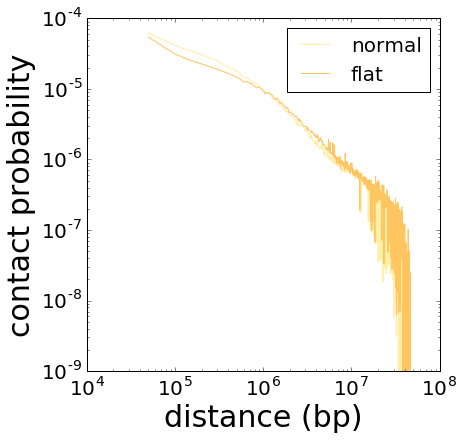

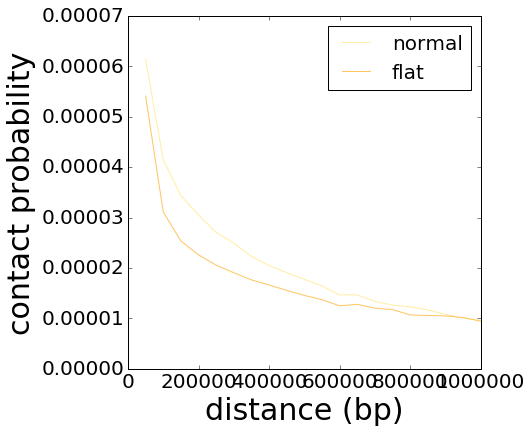

In [135]:
#now, score these matrices with genomedisco
def get_sqrtvc(m):
    rowsums=m.sum(axis=1)
    sqrt_rowsums=np.sqrt(rowsums)
    normed=np.zeros(m.shape)
    for r in range(m.shape[0]):
        if sqrt_rowsums[r]==0.0:
            continue
        normed[r,:]=1.0*m[r,:]/sqrt_rowsums[r]
    for r in range(m.shape[0]):
        if sqrt_rowsums[r]==0.0:
            continue
        normed[:,r]=1.0*normed[:,r]/sqrt_rowsums[r]
    return normed

t=3
scores={}
for dataset in rescaled_data:
    scores[dataset]=[]
    for noise_value in noises:
        m1=get_sqrtvc(rescaled_data[dataset])
        m2=get_sqrtvc(noise[dataset][noise_value])
    
        rowsums_1=m1.sum(axis=1)                                                                          
        nonzero_1=[i for i in range(rowsums_1.shape[0]) if rowsums_1[i]>0.0]
        rowsums_2=m2.sum(axis=1)                                                                           
        nonzero_2=[i for i in range(rowsums_2.shape[0]) if rowsums_2[i]>0.0]
        nonzero_total=len(list(set(nonzero_1).union(set(nonzero_2))))
        nonzero_total=0.5*(1.0*len(list(set(nonzero_1)))+1.0*len(list(set(nonzero_2))))
    
        rw1=np.linalg.matrix_power(m1,t)
        rw2=np.linalg.matrix_power(m2,t)
        score=1-abs(rw1-rw2).sum()/nonzero_total
        scores[dataset].append(score)
        
print scores

dd={}
for dataset in rescaled_data:  
    dd[dataset]=get_distance_dep(rescaled_data[dataset])
    
plot_dds([dd['normal'],dd['flat']],
             ['normal','flat'],'out',50000,'log')

plot_dds([dd['normal'],dd['flat']],
             ['normal','flat'],'out',50000,'nonlog')


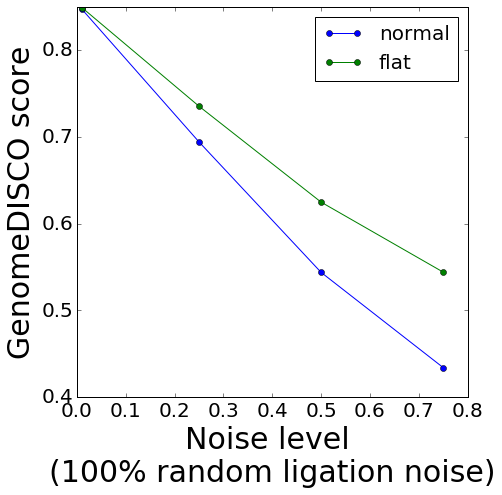

In [136]:
plt.plot(noises,scores['normal'],'-o',label='normal')
plt.plot(noises,scores['flat'],'-o',label='flat')
plt.legend(loc=1,fontsize=20)
plt.ylabel('GenomeDISCO score')
plt.xlabel('Noise level \n(100% random ligation noise)')
plt.show()

Indeed, as expected the sample with the flatter distance dependence curve displays GenomeDISCO scores that decrease less as noise is added.